# Multivariate Timeseries Forecast Case Study
##### Nicholas Solano (nsolano@indiana.edu)
##### December 2, 2021
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import datetime

### In this timeseries forecasting case study, we will walk through a process to forecast the dollar sales of a retail store using a multivariate model called Vector Autoregression.
Overview of the methods used in this guide:
1. We will bring in the sales data to be forecast along with external features suspected to be predictors of the store's sales.
2. Data cleaning and transformations will be applied to the datasets to prepare them for input into the forecasting model.
3. Feature selection process based on cross correlation between sales and shifted external features
4. Stationarity assumption checked and a differencing transformation applied to the selected input data
5. Adjust fitting parameters of the VAR model; lag order and trend
6. Run the forecast and check accuracy

#### Begin by loading in the time series data you would like to forecast as a Pandas dataframe. In this case, it is the daily sales figures for a certain retail store

In [2]:
# Read sales data as a pandas dataframe and specify that the column 'date' should be treated as a datetime type
sales_df = pd.read_csv("sales_data.csv", parse_dates=["date"], index_col="date")
sales_df.head()

,sales
date,
2019-01-02,35045.283
2019-01-03,23172.310
2019-01-04,16783.565
2019-01-05,633.360
2019-01-07,15825.297


#### Perform data quality checks on the sales data
check for missing days in the sales_df timeseries

In [3]:
# The sales data is a daily time series. To check for missing days, we will create a complete daily series between the min and max dates of the sales data to compare against

# Utilize pandas' convenient date_range function
complete_date_range = pd.date_range(start=sales_df.index.min(), end=sales_df.index.max())

# It is important to have sufficient background knowledge of the data you are analyzing.
# In this instance, the store in question is closed on weekends so we expect those days to be missing.
# To account for this, eliminate weekends from the complete_date_range series we will be using to check for missing days.
complete_date_range = complete_date_range[~complete_date_range.strftime("%A").isin(['Saturday', 'Sunday'])]

# Note that '~' is the 'not' operator for filtering in pandas

# complete_date_range only includes weekdays. We can now compare it against the date column in sales_df
missing_days = complete_date_range[~complete_date_range.isin(sales_df.index)]
print("Count of missing days from sales_df: ", len(missing_days))

Count of missing days from sales_df:  21


Impute values for the missing days in sales_df

In [4]:
# Now that the missing days are known, we should fill them in with reasonable estimated values
# To do this, we will utilize pandas' interpolate function which fills in missing values according to a specified algorithm (linear interpolation by default)

# the interpolate function fills in None type (or NaN type) values. In this case, the missing days do not exist at all
# so NaN values will need to be added before interpolating

sales_df = sales_df.append(pd.DataFrame({"sales": [np.nan]*len(missing_days)}, index=missing_days)).sort_index()
sales_df['sales'] = sales_df.sales.interpolate()

#### Load in the external features which we suspect are predictive of sales and will potentially be used in a multivariate forecasting model

Read the external features into a pandas dataframe

In [5]:
ex_df = pd.read_csv("external_features.csv", parse_dates=["date"], index_col="date")
ex_df.head()
# For the sake of this case study, the features will have generic labels.

,c1,c2,c3,c4,c5,c6
date,,,,,,
2019-01-02,5609225.0,3752941.0,1838476,239050,206452,454456
2019-01-03,5967470.0,3997130.0,2035143,274265,221203,503820
2019-01-04,6471233.0,4453551.0,2250923,313719,233357,516348
2019-01-05,6221456.0,3919573.0,2066432,268676,174353,407606
2019-01-06,5054279.0,3067421.0,1597432,345049,195378,418908


The timeseries forecasting models we will be using require each timeseries feature to have the same length. Let's verify that the external features match the sales data in days / length

In [6]:
# See which dates of ex_df are not in sales_df
ex_df[~ex_df.index.isin(sales_df.index)]

,c1,c2,c3,c4,c5,c6
date,,,,,,
2019-01-06,5054279.0,3067421.0,1597432,345049,195378,418908
2019-01-13,3784622.0,2263297.0,1205824,138867,92204,199180
2019-01-20,4547609.0,2608967.0,1500138,239673,159062,346005
2019-01-27,5559127.0,3189519.0,1727241,370292,203169,445045
2019-02-03,4980153.0,3069902.0,1629816,318648,180911,393498
...,...,...,...,...,...,...
2021-08-01,6309657.0,3614761.0,2359735,386458,76005,203453
2021-08-07,8259763.0,4733215.0,3112778,529476,105214,275479
2021-08-08,7133443.0,3982453.0,2653698,460907,90490,244045


So there are 233 days of data in the external features but not in the sales data. Are these dates the weekends that we know are excluded from sales?

In [7]:
# What are the weekday names of the days within ex_df that are not in sales_df?
ex_df[~ex_df.index.isin(sales_df.index)].index.strftime("%A").unique()

Index(['Sunday', 'Saturday'], dtype='object', name='date')

That confirms it. The unique day names of the dates in ex_df but not in sales_df are only Saturday and Sunday, the weekends. We'll account for weekends in the sales data in a later step<br><br>

#### Analyze the cross correlation of external features to sales

To begin this step, let's visually explore just the first external feature against sales data

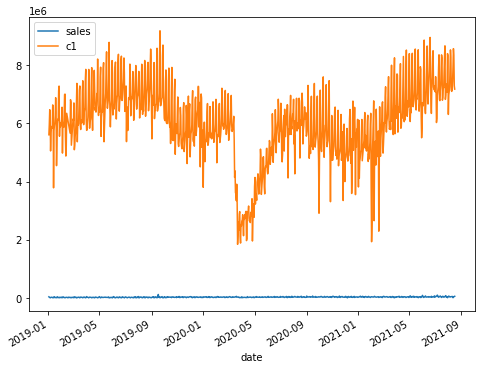

In [8]:
ax = sales_df.sales.plot(figsize=(8,6), label="sales")
ex_df.c1.plot(ax=ax, label="c1")
ax.legend()
plt.show()

Well that is not useful at all. The scale of c1 totally overwhelms sales. It would be better to normalize the metrics to the same scale to get a better view of how they correlate with each other.

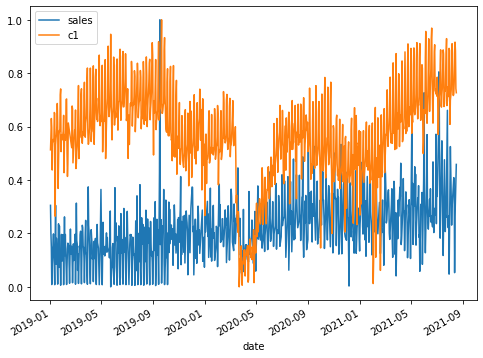

In [9]:
# define a function to normalize a series to a 0-100 min-max scale
def min_max_normalize(dataset):
    return (dataset - dataset.min()) / (dataset.max() - dataset.min())

# normalize and plot again
ax = min_max_normalize(sales_df.sales).plot(figsize=(8,6), label="sales")
min_max_normalize(ex_df.c1).plot(ax=ax, label="c1")
ax.legend()
plt.show()

Now we can begin to see similar patterns in both datasets But, two things stand out. There is a severe dip in both datasets at the time of the COVID lockdowns in the USA which occurred at the end of March 2020. It is reasonable to assume that patterns in this data may be different before and after the lockdown dip, so let's focus on the post-lockdown data. From the graph, it looks like recovery from the lockdown dip returns to a stable level near July 2020 so we'll trim off anything before then. Doing so will also clean up what look like quality problems in the 2019 sales data (notice the massive spike around 2019-09?)

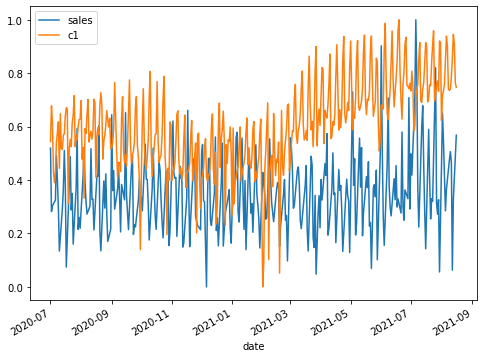

In [10]:
ax = min_max_normalize(sales_df[sales_df.index >= "2020-07-01"].sales).plot(figsize=(8,6), label="sales")
min_max_normalize(ex_df[ex_df.index >= "2020-07-01"].c1).plot(ax=ax, label="c1")
ax.legend()
plt.show()

This is a much cleaner view and you can start to see some cross correlation between the two sets. Remeber we still need to deal with the lack of weekend data in sales_df. An effective data transformation that can help with this is to apply a rolling average to each timeseries. This will help smooth out the weekly seasonal trends which will negatively impact the accuracy of the forecasting models.

In [32]:
# Apply a 4-week rolling average to the trimmed ex_df and sales_df
transformed_sales_df = min_max_normalize(sales_df[sales_df.index >= "2020-07-01"].rolling(7, center=False).mean()) * 100 # multiply by 100 for easier number readability
transformed_ex_df = min_max_normalize(ex_df[ex_df.index >= "2020-07-01"].rolling(7, center=False).mean()) * 100

# While we're at in, let's inpute weekend data into the transformed_sales_df
missing_sales_weekends = transformed_ex_df[~transformed_ex_df.index.isin(transformed_sales_df.index)].index
transformed_sales_df = transformed_sales_df.append(pd.DataFrame({"sales": [np.nan]*len(missing_sales_weekends)}, index=missing_sales_weekends)).sort_index()
transformed_sales_df['sales'] = transformed_sales_df.sales.interpolate()

Plot the transformed data. The noise has been subdued and we are left with clearer patterns.

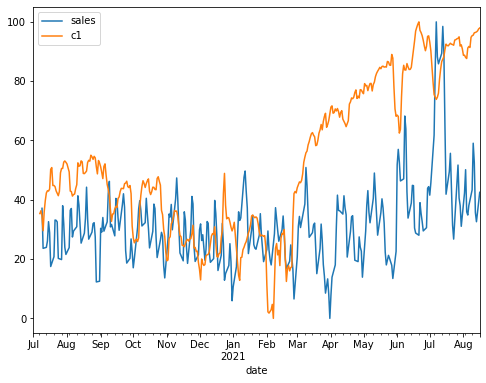

In [33]:
ax = transformed_sales_df.sales.plot(figsize=(8,6), label="sales")
transformed_ex_df.c1.plot(ax=ax, label="c1")
ax.legend()
plt.show()

Now let's calculate the correlation coefficient between these two metrics to see if there is really predictive power in the external features or not. Mostly we want to see the correlation after shifting the external feature by some number of days. Let's focus on weeks, so 7, 14, 21, 28 day shifts.

In [41]:
for shift in range(0,29,7):
    print("Cross Correlation with {}-day shift".format(shift), round(transformed_sales_df.sales.corr(transformed_ex_df.c1.shift(shift)),2))

Cross Correlation with 0-day shift 0.37
Cross Correlation with 7-day shift 0.38
Cross Correlation with 14-day shift 0.49
Cross Correlation with 21-day shift 0.52
Cross Correlation with 28-day shift 0.47


So the 21-day shift has the highest cross correlation. What does that look like on a graph?

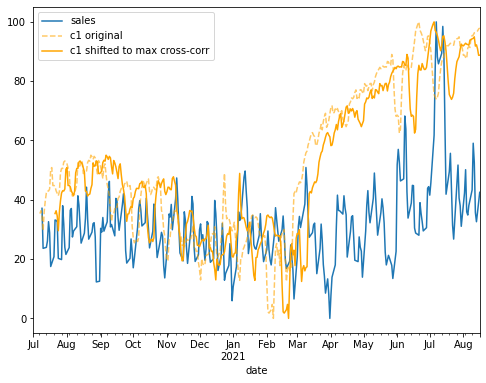

In [46]:
ax = transformed_sales_df.sales.plot(figsize=(8,6), label="sales")
transformed_ex_df.c1.plot(ax=ax, label="c1 original", color='orange', linestyle='--', alpha=0.6)
transformed_ex_df.c1.shift(14).plot(ax=ax, label="c1 shifted to max cross-corr", color='orange', linestyle='-', alpha=1.0)
ax.legend()
plt.show()

Let's do the same thing to the other external features

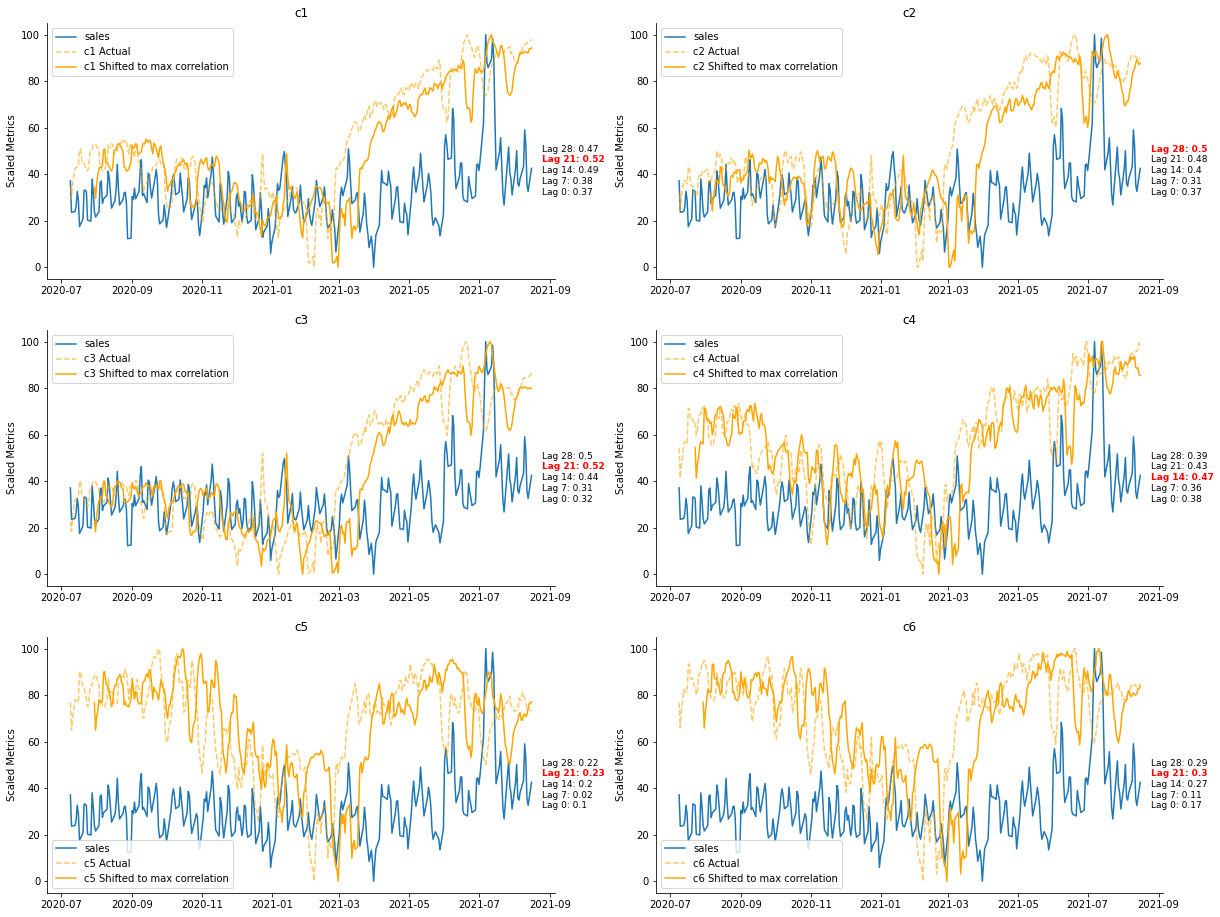

In [68]:
# Form a dataframe containing the external features and the sales data
all_data = deepcopy(transformed_ex_df.merge(transformed_sales_df, left_index=True, right_index=True).dropna()) # might as well drop the nan values which are the consequence of applying the rolling average

fig, ax = plt.subplots(3,2, figsize=(20,16))

for i, sub_ax in enumerate(ax.flatten()):
    if i > len(all_data.columns)-1:
        break
    
    sub_ax.plot(all_data.sales, label="sales")
    sub_ax.plot(all_data[all_data.columns[i]], label=all_data.columns[i]+" Actual", linestyle='--', alpha=0.6, color='orange')
    
    # Calculate the cross correlation for day lags 28, 21, 14, 7, and 0
    # cross_corrs_txt are the text labels which will be placed on each sub_ax
    cross_corrs_txt = ["Lag {}: ".format(lag)+str(round(all_data.sales.corr(all_data[all_data.columns[i]].shift(lag)),2)) for lag in [x for x in range(28,-7,-7)]]
    
    # cross_corrs_vals will be used to check which cross correlation is the highest
    cross_corrs_vals = np.array([all_data.sales.corr(all_data[all_data.columns[i]].shift(lag)) for lag in [x for x in range(28,-7,-7)]])

    y_loc_step, y_loc_start = 0.042, 0.55
    for ii, cc in enumerate(cross_corrs_vals):

        y_loc = y_loc_start - ((ii+1)*y_loc_step)
        
        # Graph the feature shifted to its maximum cross correlation
        if cc == cross_corrs_vals.max():
            # Highlight the highest cross correlation with red-bold text
            sub_ax.text(x=0.975, y=y_loc, s=cross_corrs_txt[ii], transform=sub_ax.transAxes, fontsize=9, va='center', fontweight='bold', color='red')
            sub_ax.plot(all_data[all_data.columns[i]].shift([x for x in range(28,-7,-7)][ii]), label=all_data.columns[i]+" Shifted to max correlation", color='orange')
        else:
            sub_ax.text(x=0.975, y=y_loc, s=cross_corrs_txt[ii], transform=sub_ax.transAxes, fontsize=9, va='center')
    
    sub_ax.legend()
    sub_ax.set_ylabel("Scaled Metrics")
    sub_ax.set_title(all_data.columns[i])
    
    # Hide plot borders
    sub_ax.spines['top'].set_visible(False)
    sub_ax.spines['right'].set_visible(False)
    
    # remove redundant x-axis date label
    sub_ax.set_xlabel("")

This chart allows us to pick the external metrics with the highest cross correlation at same time shifts to sales as input into a forecasting model. We will pick the ones with relatively high correlation at a 21-day lag, so c1, c2, and c3.

In [69]:
input_data = all_data[["sales", "c1", "c2", "c3"]] # Select sales, and the columns we determined as having the highest predictive power

nobs = 30 # The train/test split and the number of time steps (days) we want to forecast.
data_train, data_test = input_data[0:-nobs], input_data[-nobs:]

# Validate sizes of our training and test sets
print(data_train.shape)
print(data_test.shape)

(374, 4)
(30, 4)


***
A fundamental assumption for modeling timeseries is that the series is stationary: https://www.statisticshowto.com/stationarity/<br><br><br>
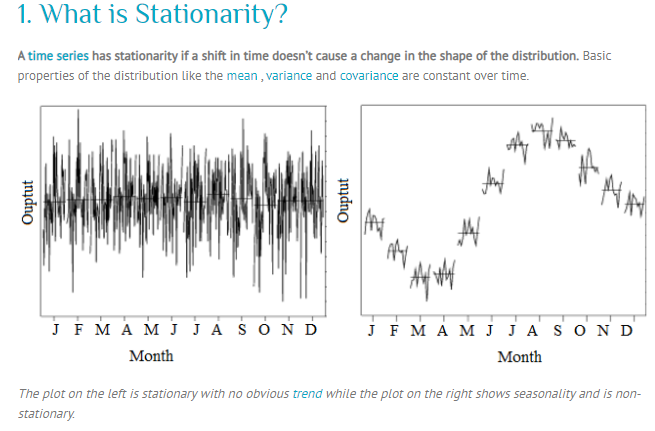<br>
The below function is a standard way of checking for stationarity in our timeseries. Let's check the data as it is now.

In [73]:
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is {} stationary?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'NOT' if v < dftest[0] else '', 100 - int(k[:-1])))
    print("\n")
    
    
for c in data_train.columns:
    ADF_test(data_train[c], c)    

 > Is sales stationary?
Test statistic = -3.530
P-value = 0.007
Critical values :
	1%: -3.44880082033912 - The data is  stationary with 99% confidence
	5%: -2.869670179576637 - The data is  stationary with 95% confidence
	10%: -2.5711012838861036 - The data is  stationary with 90% confidence


 > Is c1 stationary?
Test statistic = -0.579
P-value = 0.876
Critical values :
	1%: -3.44880082033912 - The data is NOT stationary with 99% confidence
	5%: -2.869670179576637 - The data is NOT stationary with 95% confidence
	10%: -2.5711012838861036 - The data is NOT stationary with 90% confidence


 > Is c2 stationary?
Test statistic = -0.989
P-value = 0.757
Critical values :
	1%: -3.44880082033912 - The data is NOT stationary with 99% confidence
	5%: -2.869670179576637 - The data is NOT stationary with 95% confidence
	10%: -2.5711012838861036 - The data is NOT stationary with 90% confidence


 > Is c3 stationary?
Test statistic = -0.780
P-value = 0.825
Critical values :
	1%: -3.44880082033912 -

Only the sales data is stationary so we will have to apply another transformation. Differencing is a standard method of turning a non-stationary dataset stationary.

In [74]:
differenced_column_names = {}
for c in input_data:
    differenced_column_names[c] = c+"_1d" # 'first difference' labels for the differenced columns
data_differenced = input_data.diff().dropna().rename(columns=differenced_column_names)

Retest stationarity

In [75]:
for c in data_differenced.columns:
    ADF_test(data_differenced[c], c)

 > Is sales_1d stationary?
Test statistic = -8.007
P-value = 0.000
Critical values :
	1%: -3.4474946672686824 - The data is  stationary with 99% confidence
	5%: -2.8690962436986855 - The data is  stationary with 95% confidence
	10%: -2.570795299750434 - The data is  stationary with 90% confidence


 > Is c1_1d stationary?
Test statistic = -5.321
P-value = 0.000
Critical values :
	1%: -3.447360865754795 - The data is  stationary with 99% confidence
	5%: -2.8690374364690445 - The data is  stationary with 95% confidence
	10%: -2.5707639493486636 - The data is  stationary with 90% confidence


 > Is c2_1d stationary?
Test statistic = -5.301
P-value = 0.000
Critical values :
	1%: -3.447360865754795 - The data is  stationary with 99% confidence
	5%: -2.8690374364690445 - The data is  stationary with 95% confidence
	10%: -2.5707639493486636 - The data is  stationary with 90% confidence


 > Is c3_1d stationary?
Test statistic = -5.513
P-value = 0.000
Critical values :
	1%: -3.447405233596701 

We now have an input dataset that is stationary. Let's split into train and test sets again and start modeling.

In [76]:
data_train_differenced, data_test_differenced = data_differenced[0:-nobs], data_differenced[-nobs:]

# Validate sizes of our training and test sets
print(data_train_differenced.shape)
print(data_test_differenced.shape)

(373, 4)
(30, 4)


The timeseries analysis model we will be using is __[Vector Autoregression](https://en.wikipedia.org/wiki/Vector_autoregression)__, a standard model for multivariate timeseries forecasting.

In [79]:
from statsmodels.tsa.api import VAR

model = VAR(data_train_differenced, freq='D')

We now have a model trained on 373 days of data. Before we run the forecast, there is a paramert we need to decide on called the lag order. The lag order indicates how far back the features should be included when decided a forecast value. Experiment with different lag orders or have the model pick one for you based on built-in lag order algorithms

In [80]:
model.select_order().selected_orders

{'aic': 16, 'bic': 1, 'hqic': 8, 'fpe': 16}

In [81]:
#lag_order = model.select_order().selected_orders["aic"]
lag_order = 21
print("Lag Order: {}".format(lag_order))

Lag Order: 21


For this iteration of the model we'll pick 21 days, the same shift we based our feature selection on earlier.

In [82]:
trend_parameter = 'n' # The trend parameter is another dial that can be adjusted when iterating on the model to improve accuracy.
model_fit = model.fit(lag_order, trend=trend_parameter)

The model is now fitted with our chosen parameters. All that is left is to run the forecast!

In [83]:
forecast = pd.DataFrame(model_fit.forecast(y=data_train_differenced[-lag_order:].values, steps=nobs), index=input_data.index[-nobs:], columns=data_differenced.columns)

Forecast is a dataframe of the same shape and time range as our the test data. They can be plotted against each other to visualize how accurate the forecast is

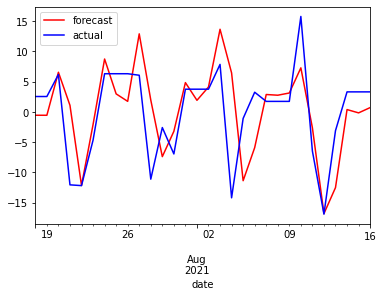

In [87]:
ax = forecast.sales_1d.plot(color='red', label="forecast")
data_test_differenced.sales_1d.plot(ax=ax, color='blue', label="actual")
ax.legend()
plt.show()

This looks promising but remember this is on the differenced data. We need to revert the forecast back to undifferenced units.

To better interpret the forecast. Revert the differencing operation and compare it directly with the undifferenced test data

In [98]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [99]:
forecast_undifferenced = invert_transformation(data_train, forecast)

In [100]:
forecast_undifferenced[0:1]

,sales_1d,c1_1d,c2_1d,c3_1d,sales_forecast,c1_forecast,c2_forecast,c3_forecast
date,,,,,,,,
2021-07-18,-0.555558,0.204116,-1.725712,0.113913,43.857421,92.233308,86.362,80.336874


Let's visualize the forecast now along with leading actual values

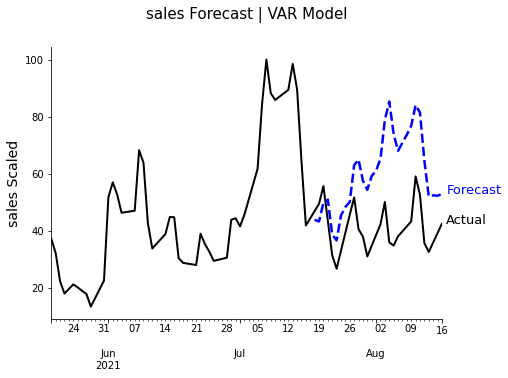

In [122]:
c = 'sales'
ax = input_data[c][-nobs*3:].plot(figsize=(7,5), label="Actual", color='black', linewidth=2.0)
forecast_undifferenced[c+"_forecast"].plot(ax=ax, color='blue', linestyle="--", linewidth=2.5, label="Forecast")
ax.set_title(c+" Forecast | VAR Model", pad=28, fontsize=15)
ax.set_xlabel("")
ax.set_ylabel(c+" Scaled", fontsize=14)
#ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(x=forecast_undifferenced[c+"_forecast"].index[-1]+datetime.timedelta(days=1), y=forecast_undifferenced[c+"_forecast"][-1], s="Forecast", fontsize=13, color='blue')
ax.text(x=input_data[c][-nobs*3:].index[-1]+datetime.timedelta(days=1), y=input_data[c][-nobs*3:][-1], s="Actual", fontsize=13)

plt.show()

Now let's formally check the accuracy of the forecast by running a lineup of statistical accuracy metrics

In [123]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr})

def adjust(val, length= 6): return str(val).ljust(length)

c = 'sales_forecast'
print('Forecast Accuracy of: ' + c)
accuracy_prod = forecast_accuracy(forecast_undifferenced['sales_forecast'].values, data_test['sales'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
print("")

Forecast Accuracy of: sales_forecast
mape   :  0.5093
me     :  18.9896
mae    :  19.9972
mpe    :  0.4895
rmse   :  22.9784
corr   :  0.3444



MAPE is the mean absolute percentage error. It represents the average difference between forecasted values and the actual values. Our 50% MAPE is not too great, but for a first-pass at the forecast it is promising, especially since the forecasted line follows closely the pattern of the actual line.
***

Extra resources to lean about time series analysis

https://people.duke.edu/~rnau/411home.htm

https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

